In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform,glorot_normal
from keras.models import Model, load_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
DATADIR = "C:/Users/Arpan/Downloads/Education/Project/Rubics Cube/training/"
labels = pd.read_csv(DATADIR+str('labels.csv'))

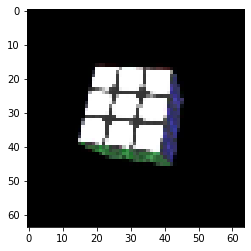

In [9]:
# reducing the sizes
path = DATADIR+str('images')
for img in os.listdir(path):
        img_array = np.array(cv2.imread(os.path.join(path,img)))
        img_size = 64
        new_array = cv2.resize(img_array,(img_size,img_size))
        plt.imshow(new_array)
        plt.show()
        break

In [10]:
path = os.path.join(DATADIR+str('images'))
training_data = []
def create_training_data():    
    for img in os.listdir(path):
        img_array = np.array(cv2.imread(os.path.join(path,img)))
        img_size = 64
        new_array = cv2.resize(img_array,(img_size,img_size))
        training_data.append([new_array, labels.xRot[labels.filename==img].values])

create_training_data()

In [11]:
import random
random.shuffle(training_data)
X =[]
y = []
img_size = 64
for feature,label in training_data:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1,img_size,img_size,3)


In [12]:
y = np.array(y).reshape(-1,1)

In [13]:
import pickle
pickle_out = open('X.pickle','wb')
pickle.dump('X',pickle_out)
pickle_out.close()

pickle_out = open('y.pickle','wb')
pickle.dump('y',pickle_out)
pickle_out.close()

In [14]:
# scaling
X = X/255.

In [15]:
# spilitting the data
train_size = int(0.8 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

ResNET50


In [16]:
# identity block

def identity_block(X, f, filters, stage, block):
    
    
    #  name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    #  Filters
    F1, F2, F3 = filters
    
    #  input value. 
    X_shortcut = X
    
    # First main path comp
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second main path comp
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [17]:
# convolutional block
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    #  name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    #  Filters
    F1, F2, F3 = filters
    
    #  input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [18]:
# RESNET 50

def ResNet50(input_shape=(512, 512, 3)):
    
    # input
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # MAXPOOL 
    X = MaxPooling2D((2,2), name="avg_pool")(X)


    # output layer
    X = Flatten()(X)
    X = Dense(1, activation='linear', name='fc', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    #  model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [19]:
model = ResNet50(input_shape=(64,64,3))

In [20]:
opt = tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error',metrics=['mean_squared_error'],optimizer=opt)

In [23]:
epochs = 50
batch_size = 128

model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 21s 5ms/step - loss: 29.8777 - mean_squared_error: 29.8777 - val_loss: 30.1739 - val_mean_squared_error: 30.1739
Epoch 2/50
4000/4000 [==============================] - 18s 5ms/step - loss: 12.9980 - mean_squared_error: 12.9980 - val_loss: 60.9753 - val_mean_squared_error: 60.9753
Epoch 3/50
4000/4000 [==============================] - 18s 5ms/step - loss: 19.4948 - mean_squared_error: 19.4949 - val_loss: 63.6263 - val_mean_squared_error: 63.6263
Epoch 4/50
4000/4000 [==============================] - 18s 5ms/step - loss: 19.7533 - mean_squared_error: 19.7533 - val_loss: 6.8972 - val_mean_squared_error: 6.8972
Epoch 5/50
4000/4000 [==============================] - 18s 5ms/step - loss: 24.6690 - mean_squared_error: 24.6690 - val_loss: 79.6541 - val_mean_squared_error: 79.6541
Epoch 6/50
4000/4000 [==============================] - 18s 5ms/step - loss: 26.8165 - mean_squared_error: 26

Epoch 50/50
4000/4000 [==============================] - 18s 5ms/step - loss: 0.5902 - mean_squared_error: 0.5902 - val_loss: 0.4152 - val_mean_squared_error: 0.4152


In [24]:
print(model.evaluate(X_test,y_test))

1000/1000 [==============================] - 2s 2ms/step
[0.4151562452316284, 0.41515618562698364]


<b>Testing on unknown data

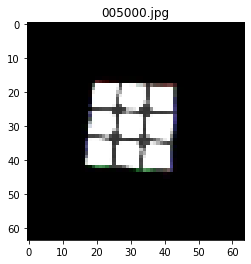

In [28]:
DATADIR = "C:/Users/Arpan/Downloads/Education/Project/Rubics Cube/"
path = os.path.join(DATADIR+str('images'))
for img in os.listdir(path):
        img_array = np.array(cv2.imread(os.path.join(path,img)))
        img_size = 64
        new_array = cv2.resize(img_array,(img_size,img_size))
        plt.imshow(new_array)
        plt.title(img)
        plt.show()
        break

In [30]:
DATADIR = "C:/Users/Arpan/Downloads/Education/Project/Rubics Cube/"
path = os.path.join(DATADIR+str('images'))
test_data = []
filename = []
def create_test_data():    
    for img in os.listdir(path):
        img_array = np.array(cv2.imread(os.path.join(path,img)))
        img_size = 64
        new_array = cv2.resize(img_array,(img_size,img_size))
        test_data.append(new_array)
        filename.append(img)

create_test_data()

In [34]:
X_sub = []
for feature in test_data:
    X_sub.append(feature)

img_size = 64
X_sub = np.array(X_sub).reshape(-1,img_size,img_size,3)
X_sub.shape

(5001, 64, 64, 3)

In [41]:
# prediction
X_sub = X_sub/255. #scaling
prediction = model.predict(X_sub)

In [42]:
prediction[:10]

array([[348.86542 ],
       [261.8329  ],
       [292.77127 ],
       [111.37445 ],
       [  6.5502  ],
       [150.90115 ],
       [348.88196 ],
       [ 39.141468],
       [231.62665 ],
       [144.95145 ]], dtype=float32)

Making submission

In [44]:
submission = pd.DataFrame(filename, columns=['filename'])
submission['xRot'] = prediction
submission.head()

,filename,xRot
0,005000.jpg,348.865417
1,005001.jpg,261.832886
2,005002.jpg,292.771271
3,005003.jpg,111.374451
4,005004.jpg,6.550200


In [45]:
submission.to_csv('submission_Rubics.csv',index = False)